# Using Machine Learning to Analyze Voice Disorders for Parkinson's Disease Detection

In [2]:
# !pip install dtreeviz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

Creating Helper Function for plotting

In [3]:
sns.set(style="whitegrid", color_codes=True)
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = 3*cm.max()/4
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Parkinson Data and Voice Disorder
Voice disorder dataset can be used to detect the presence of Parkinson's disease in an individual. While current tools have limitations in analyzing complex voice disorders, advancements in technology and research have enabled the development of new algorithms that can identify specific acoustic markers associated with Parkinson's disease in voice recordings. Therefore, the analysis of voice disorders can provide valuable information in diagnosing and monitoring Parkinson's disease.

This dataset is composed of a range of biomedical voice measurements from 31 people, 23 with Parkinson's disease (PD). Our dataset includes voice attributes Information that can be used for detecting parkinson, these information including:

Matrix column entries (attributes):

name - ASCII subject name and recording number
MDVP:Fo(Hz) - Average vocal fundamental frequency
MDVP:Fhi(Hz) - Maximum vocal fundamental frequency
MDVP:Flo(Hz) - Minimum vocal fundamental frequency
Five measures of variation in Frequency
MDVP:Jitter(%) - Percentage of cycle-to-cycle variability of the period duration
MDVP:Jitter(Abs) - Absolute value of cycle-to-cycle variability of the period duration
MDVP:RAP - Relative measure of the pitch disturbance
MDVP:PPQ - Pitch perturbation quotient
Jitter:DDP - Average absolute difference of differences between jitter cycles
Six measures of variation in amplitude
MDVP:Shimmer - Variations in the voice amplitdue
MDVP:Shimmer(dB) - Variations in the voice amplitdue in dB
Shimmer:APQ3 - Three point amplitude perturbation quotient measured against the average of the three amplitude
Shimmer:APQ5 - Five point amplitude perturbation quotient measured against the average of the three amplitude
MDVP:APQ - Amplitude perturbation quotient from MDVP
Shimmer:DDA - Average absolute difference between the amplitudes of consecutive periods
Two measures of ratio of noise to tonal components in the voice
NHR - Noise-to-harmonics Ratio and
HNR - Harmonics-to-noise Ratio
status - Health status of the subject (one) - Parkinson's, (zero) - healthy
Two nonlinear dynamical complexity measures
RPDE - Recurrence period density entropy
D2 - correlation dimension
DFA - Signal fractal scaling exponent
Three nonlinear measures of fundamental frequency variation
spread1 - discrete probability distribution of occurrence of relative semitone variations
spread2 - Three nonlinear measures of fundamental frequency variation
PPE - Entropy of the discrete probability distribution of occurrence of relative semitone variations


Load the Data

In [4]:
data = pd.read_csv('parkinsons.data', sep=',', index_col='name') # assign index column to name 
# data.head()
# data.dropna()
data.mask(data.eq('None')).dropna()
data.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
name,,,,,,,,,,,,,,,,,,,,,
phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [5]:
data.shape

(195, 23)

To improve our understanding of the variables involved in parkinson detection, we first need to analyze the relationships within the data. Correlation diagrams can be helpful in visualizing how different variables are associated with each other and with parkinson status. Additionally, random forest models can help identify the importance of different features in predicting the target variable (parkinson).

Create a Correlation Matrix

<Axes: >

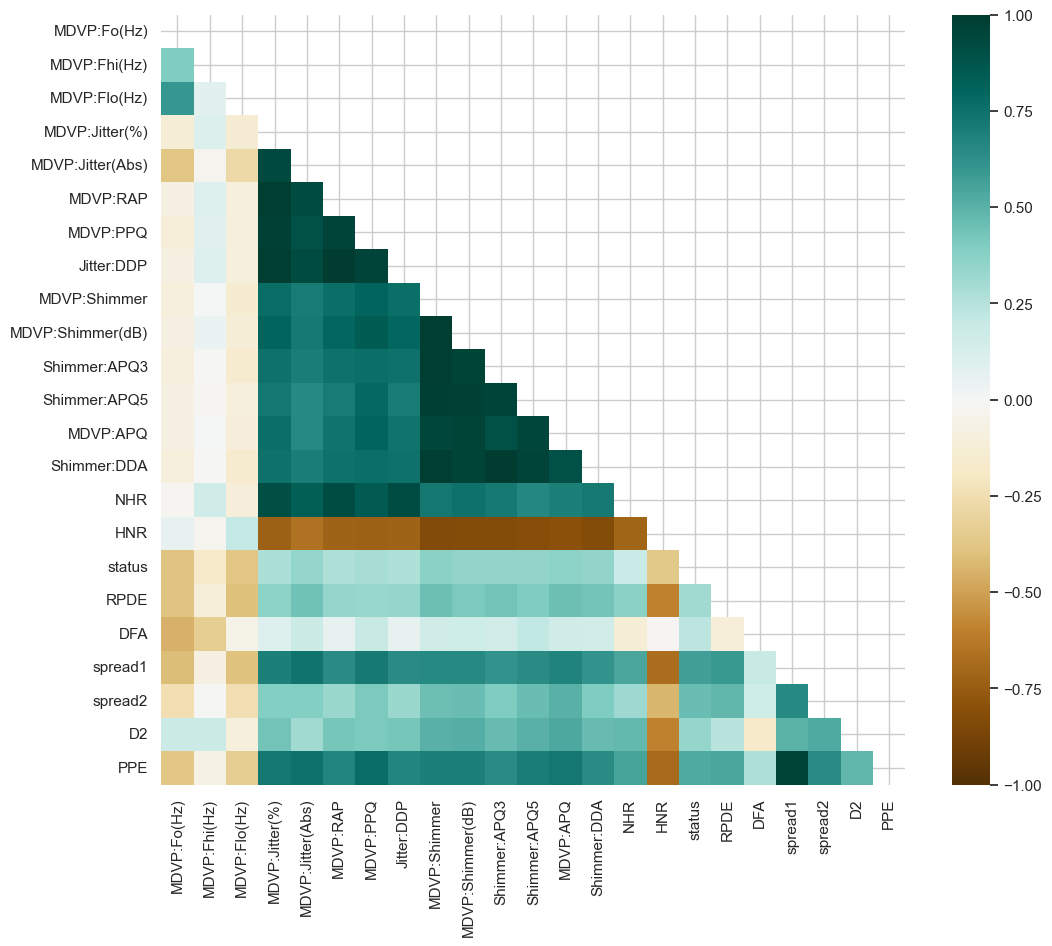

In [6]:
plt.figure(figsize=(12,10))
mask = np.triu(np.ones_like(data.corr(),dtype=np.bool))
sns.heatmap(data.corr(),vmin=-1,vmax=1,cmap='BrBG',mask=mask)


Modify the Hedmap plot to show correlation variables to the status

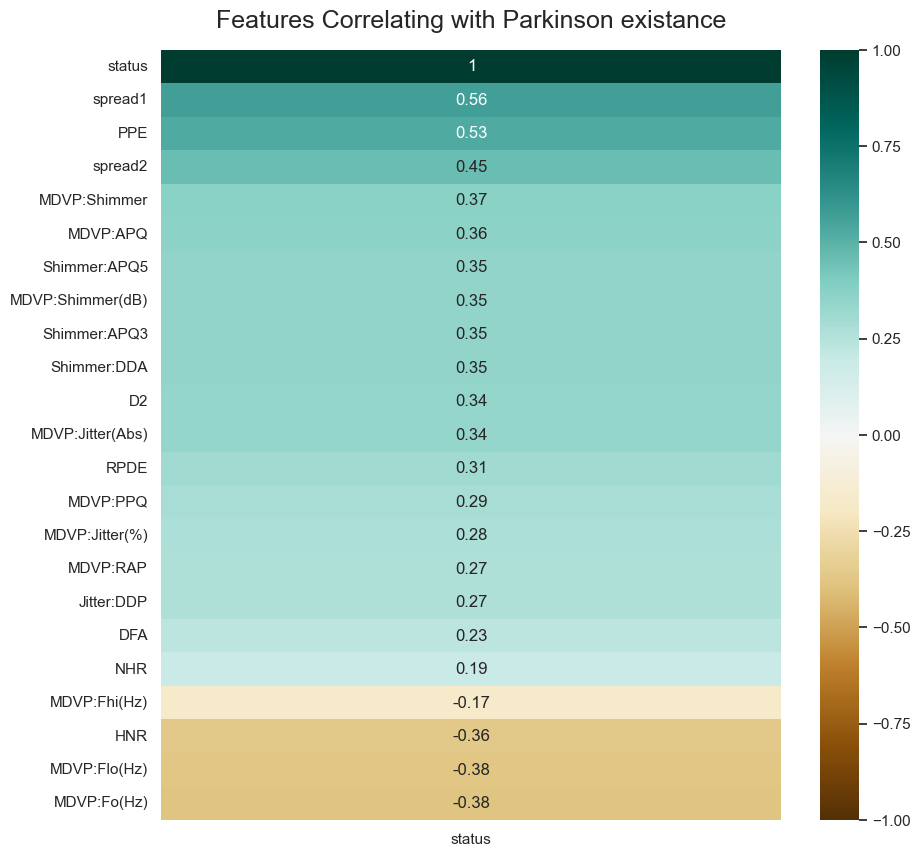

In [7]:
plt.figure(figsize=(10,10))
heatmap=sns.heatmap(data.corr()[['status']].sort_values(by='status',ascending=False),vmin=-1,vmax=1,annot=True,cmap='BrBG')
heatmap.set_title('Features Correlating with Parkinson existance',fontdict={'fontsize':18},pad=16);


In [8]:
X = data.drop('status',axis=1)
X.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
name,,,,,,,,,,,,,,,,,,,,,
phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.02971,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.04368,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.03590,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.03772,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.04465,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [9]:
# status 1 indicates Parkinson, 0 indicates healthy
y=data['status']
y.head()

name
phon_R01_S01_1    1
phon_R01_S01_2    1
phon_R01_S01_3    1
phon_R01_S01_4    1
phon_R01_S01_5    1
Name: status, dtype: int64

In [10]:
# nearly 75% of of samples are of Parkinson
y.value_counts(normalize=True)

1    0.753846
0    0.246154
Name: status, dtype: float64

t-SNE (t-Distributed Stochastic Neighbor Embedding) 

is a machine learning technique used for dimensionality reduction and visualization of high-dimensional datasets. It is particularly useful for visualizing complex data structures, as it helps to project the data points from a high-dimensional space to a lower-dimensional space (usually 2D or 3D) while preserving the relationships between the data points as much as possible. Lets apply it to our dataset:

In [11]:
X.fillna(0)

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
name,,,,,,,,,,,,,,,,,,,,,
phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.02971,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.04368,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.03590,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.03772,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.04465,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
phon_R01_S50_2,174.188,230.978,94.261,0.00459,0.00003,0.00263,0.00259,0.00790,0.04087,0.405,...,0.02745,0.07008,0.02764,19.517,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050
phon_R01_S50_3,209.516,253.017,89.488,0.00564,0.00003,0.00331,0.00292,0.00994,0.02751,0.263,...,0.01879,0.04812,0.01810,19.147,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895
phon_R01_S50_4,174.688,240.005,74.287,0.01360,0.00008,0.00624,0.00564,0.01873,0.02308,0.256,...,0.01667,0.03804,0.10715,17.883,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728


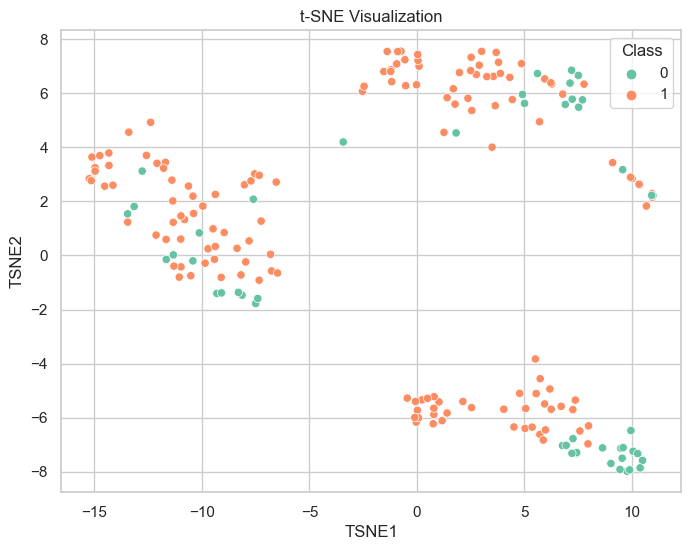

In [12]:
import seaborn as sns
from sklearn.manifold import TSNE

# Apply t-SNE to reduce the dimensions to 2
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Create a DataFrame with the t-SNE-transformed data and class labels
tsne_df = pd.DataFrame(data=X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['Class'] = y.values

# Visualize the data based on class using a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Class', palette='Set2')
plt.title('t-SNE Visualization')
plt.show()

Data preparation

Here, we are splitting a dataset into independent and dependent variables, and then splitting it further into training and testing sets.

In [13]:


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)


# print the shape of train and test data
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (136, 22)
y_train shape:  (136,)
X_test shape:  (59, 22)
y_test shape:  (59,)


k-Nearest Neighbors (k-NN)
K-NN


In k-NN, the basic idea is to predict the label of a new instance based on the labels of its k nearest neighbors in the training data.

We import the library

In [14]:
from sklearn.neighbors import KNeighborsClassifier

In [15]:
# Create KNN Model
knn = KNeighborsClassifier(n_neighbors=3)

In [16]:
# Fit the Object
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [17]:
# Now make predictions on testing Data
y_pred = knn.predict(X_test)
y_pred[0:5]

array([1, 0, 1, 1, 1])

In [18]:
knn.predict_proba(X_test)[0:10]

array([[0.33333333, 0.66666667],
       [0.66666667, 0.33333333],
       [0.33333333, 0.66666667],
       [0.33333333, 0.66666667],
       [0.        , 1.        ],
       [0.33333333, 0.66666667],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ]])

Confusion matrix, without normalization
[[ 9  3]
 [ 5 42]]

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.75      0.69        12
           1       0.93      0.89      0.91        47

    accuracy                           0.86        59
   macro avg       0.79      0.82      0.80        59
weighted avg       0.87      0.86      0.87        59


Accuracy Score: 0.864406779661017


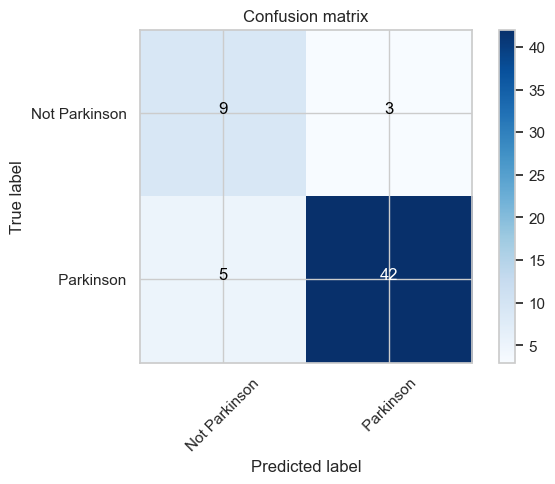

In [19]:
# Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
plot_confusion_matrix(confusion_matrix(y_test, y_pred),classes=[ "Not Parkinson", " Parkinson"],title='Confusion matrix')
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

# GridSearchCV

In the code above, we randomly selected the hyperparameter K for our KNN classifier. However, in order to find the optimal hyperparameters that maximize the performance metric, we will perform a grid search. To do this, we define a parameter grid that we will search over for K.

In [20]:
param_grid = {
    'n_neighbors': [3,5,7,9],
}

In [21]:
# Define the KNN classifier object
knn = KNeighborsClassifier()

In medical testing, recall is a measure of the ability of a test to correctly identify true positive cases, or the proportion of actual positive cases that are correctly identified by the test. A high recall means that the test is able to correctly identify a large proportion of true positive cases, even if it may also produce some false positive results, therefore for scoring we select recall . The choice of performance metric for a machine learning model may depend on several factors.

The next cell performs a grid search over the hyperparameters of a KNN classifier using GridSearchCV() function from scikit-learn library. The param_grid parameter specifies a dictionary of hyperparameters to search over, while the scoring parameter specifies the performance metric to optimize for, which in this case is the recall. The cv parameter specifies the number of folds for cross-validationv cv . The resulting grid_search object can be used to fit the data and obtain the best hyperparameters that maximize the performance metric.

In [22]:
from sklearn.model_selection import GridSearchCV


grid_search = GridSearchCV(knn, param_grid, scoring='recall', cv=5)

grid_search 

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9]}, scoring='recall')

In [23]:
# Fit the grid search to the training data

grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9]}, scoring='recall')

In [24]:
# Print the best parameters and score on validation data

print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'n_neighbors': 9}
Best Score:  0.97


In [25]:
# Get the predicted labels on the test data using the best estimator
y_pred = grid_search.best_estimator_.predict(X_test)

In [26]:
# Calculate the recall score on test data using the predicted labels:

from sklearn.metrics import recall_score
recall = recall_score(y_test,y_pred)
recall

0.9148936170212766

In [27]:
# Make predictions
y_hat = grid_search.best_estimator_.predict(X)

In [28]:
# Use  the data to train the model
knn = KNeighborsClassifier()
knn.fit(X,y)

KNeighborsClassifier()

In [29]:
# make a predictions
y_hat = knn.predict(X)

Confusion matrix, without normalization
[[ 5  7]
 [ 4 43]]


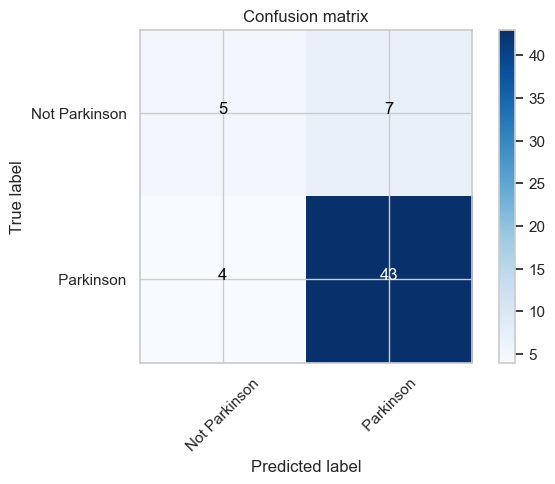

In [30]:
# Plot a confusion matrix
plot_confusion_matrix(confusion_matrix(y_test, y_pred),classes=[ "Not Parkinson", " Parkinson"],title='Confusion matrix')

Label the true positives, true negatives, and false negatives

In [31]:
# find TP
tsne_df['label'] = ''
tsne_df['label'].iloc[np.where((y_hat==1)& (y==1))]= "TP"
tsne_df['label'].iloc[np.where((y_hat==0)& (y==0))]= "TN"
tsne_df['label'].iloc[np.where((y_hat==1)& (y==0))]= "FP"
tsne_df['label'].iloc[np.where((y_hat==0)& (y==1))]= "FN"

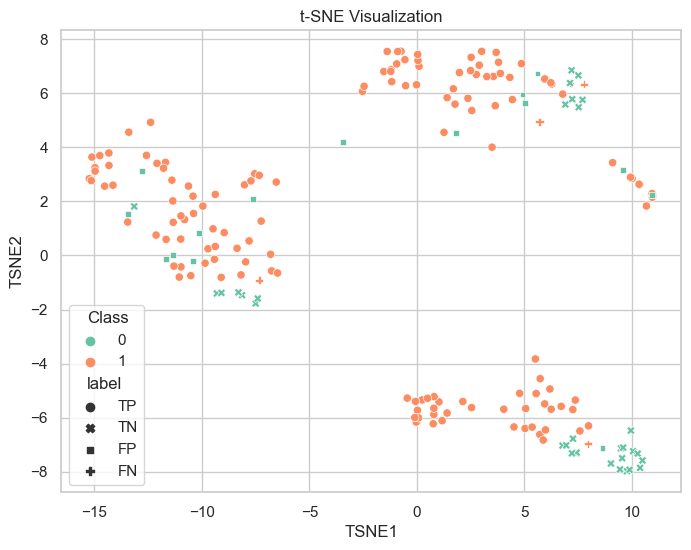

In [32]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Class', palette='Set2',style='label')
plt.title('t-SNE Visualization')
plt.show()

# Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

In [34]:
# Make predictions
y_pred = lr.predict(X_test)
y_pred[0:10]

array([1, 0, 1, 1, 1, 1, 1, 0, 0, 0])

In [35]:
# Get a probability of belonging to each class for each sample, here are the first ten
lr.predict_proba(X_test)[0:10]

array([[0.26804864, 0.73195136],
       [0.69147962, 0.30852038],
       [0.06768121, 0.93231879],
       [0.38580979, 0.61419021],
       [0.07225466, 0.92774534],
       [0.26281201, 0.73718799],
       [0.0091459 , 0.9908541 ],
       [0.51050401, 0.48949599],
       [0.85876791, 0.14123209],
       [0.90257006, 0.09742994]])

Confusion matrix, without normalization
[[ 9  3]
 [ 6 41]]

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.75      0.67        12
           1       0.93      0.87      0.90        47

    accuracy                           0.85        59
   macro avg       0.77      0.81      0.78        59
weighted avg       0.86      0.85      0.85        59


Accuracy Score: 0.847457627118644


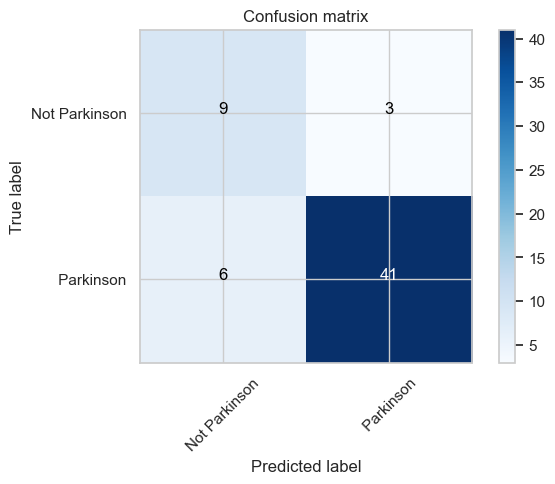

In [36]:
# Generate a Confusion Matrix
plot_confusion_matrix(confusion_matrix(y_test, y_pred),classes=[ "Not Parkinson", " Parkinson"],title='Confusion matrix')
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

While grid search can be used to optimize hyperparameters for many machine learning algorithms, the hyperparameters in logistic regression may not be particularly insightful. Instead, we can use logistic regression to identify feature importance, as the coefficients learned during training can reveal which features are most strongly associated with the target variable. We can obtain the coefficients.

In [37]:
coef = abs(lr.coef_[0])

The coefficients represent the impact of each feature on th probability of the positive class, So larger the magnitude of the coefficients are more important the feature

<BarContainer object of 22 artists>

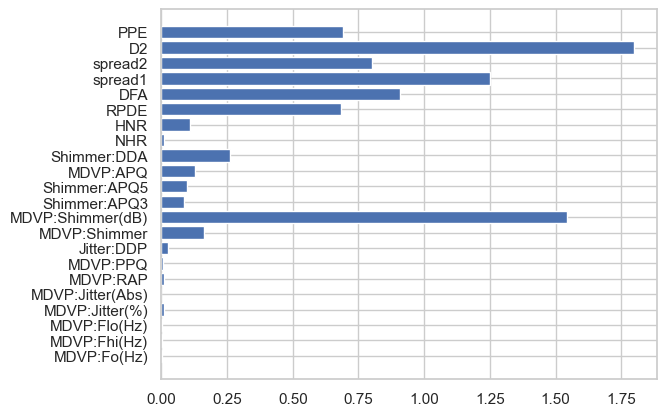

In [38]:
plt.barh(X.columns,coef)

In [39]:
# select features with highest magnitude coefficients

best_columns = X.columns[np.argsort(-1*coef)[0:5]]
best_columns

Index(['D2', 'MDVP:Shimmer(dB)', 'spread1', 'DFA', 'spread2'], dtype='object')

Confusion matrix, without normalization
[[ 9  3]
 [ 6 41]]

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.75      0.67        12
           1       0.93      0.87      0.90        47

    accuracy                           0.85        59
   macro avg       0.77      0.81      0.78        59
weighted avg       0.86      0.85      0.85        59


Accuracy Score: 0.847457627118644


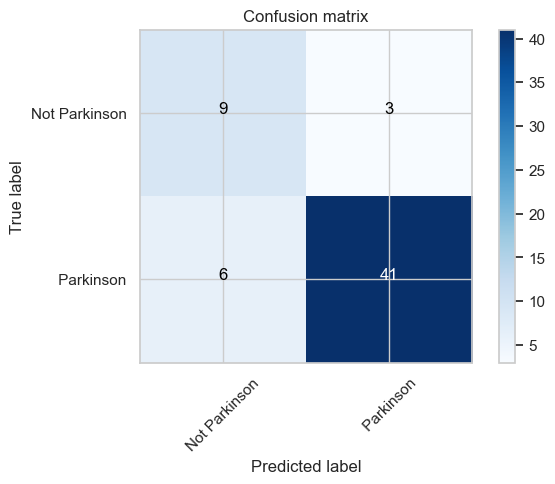

In [40]:
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train[best_columns], y_train)

# Get the predicted probabilities for each class
y_pred_proba = log_reg.predict_proba(X_test[best_columns])

plot_confusion_matrix(confusion_matrix(y_test, y_pred),classes=[ "Not Parkinson", " Parkinson"],title='Confusion matrix')
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

# Support Vector Machine (SVM)

SVM stands for Support Vector Machines. It is a type of supervised machine learning algorithm used for classification. The algorithm identifies a hyperplane (or a set of hyperplanes) in an n-dimensional space that maximally separates the different classes in the dataset. The hyperplane that is selected is the one that has the maximum margin between the closest points of different classes, known as support vectors. SVM is particularly effective in high-dimensional datasets where other algorithms may have difficulty in identifying a clear boundary between the classes. SVM is also versatile in the type of kernel functions that can be used to transform the data into higher dimensions, such as linear, polynomial, and radial basis function (RBF) kernels.

Like Logistic Regression SVM is a linear classifier but there are some Pros and Cons

Pros of SVM over Logistic Regression

Effective in high dimensional spaces and with datasets that have a lot of features
Can handle non-linearly separable data using kernel trick
Robust to overfitting due to the regularization parameter


Cons of SVM compared to Logistic Regression

Can be computationally expensive to train, especially with large datasets
Difficult to interpret the results and understand the impact of each feature on the model
Requires careful selection of hyperparameters to achieve optimal performance
You can train a SVM just like any other model

In [41]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train,y_train)


SVC()

In [42]:
# Make predictions
y_hat = svm.predict(X_test)

Confusion matrix, without normalization
[[ 4  8]
 [ 2 45]]


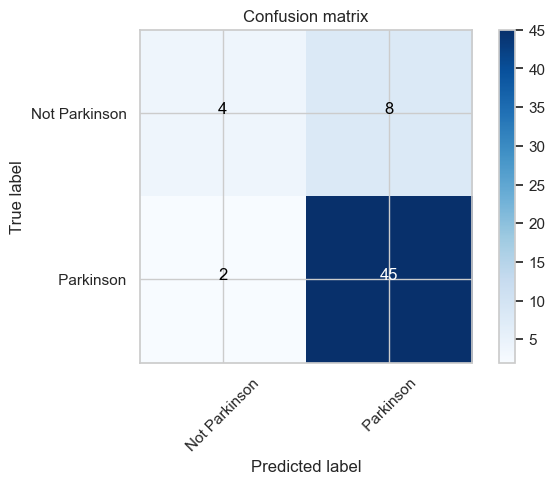

In [43]:
# generate a confusion matrix
plot_confusion_matrix(confusion_matrix(y_test, y_hat),classes=[ "Not Parkinson", " Parkinson"],title='Confusion matrix')

Here are the explanations for some of the important parameters:

C: Regularization parameter. A smaller value of C creates a wider margin but may lead to more misclassifications, while a larger value of C creates a narrower margin but may lead to overfitting

kernel: Type of kernel function used to transform the data into a higher-dimensional space where it can be linearly separated. Common choices include linear, polynomial, and radial basis function (RBF) kernels

gamma: Kernel coefficient for RBF, polynomial, and sigmoid kernels. A smaller value of gamma creates a larger influence radius for the support vectors, while a larger value of gamma creates a smaller influence radius and can lead to overfitting

degree: Degree of the polynomial kernel function. Only used for polynomial kernel.







here is a dictionary for grid search with some of the specified parameters:

In [44]:
param_grid = {
    'C': [0.1, 1,],
    'gamma': [0.1, 1, 10],

}

In [45]:
# Train the SVM classifier
svm = SVC()
# Create a GridSearchCV object
grid_search = GridSearchCV(svm, param_grid, scoring='recall', cv=2)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding recall score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best recall score: ", grid_search.best_score_)

Best hyperparameters:  {'C': 0.1, 'gamma': 0.1}
Best recall score:  1.0


# Random Forest

Random Forest is a good choice for various machine learning tasks due to its high accuracy in classifying complex data patterns. The ability to interpret the results of Random Forest models also makes it easier to validate and understand the decisions it makes.

In [46]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
# fit the data
rf.fit(X_train,y_train)
# make predictions
y_pred = rf.predict(X_test)

#get accuracies

accuracy = accuracy_score(y_test,y_pred)
print("Accuracy:{:.2f}%".format(accuracy*100))


Accuracy:94.92%


Perform Gridsearch to tune best parameters

In [47]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators':[50,100,200],
    'max_depth':[5,10,15],
    'max_features':['sqrt','log2']
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf,param_grid=param_grid,cv = 5)
grid_search.fit(X_train,y_train)

print("The best parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

The best parameters: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 100}


<Axes: >

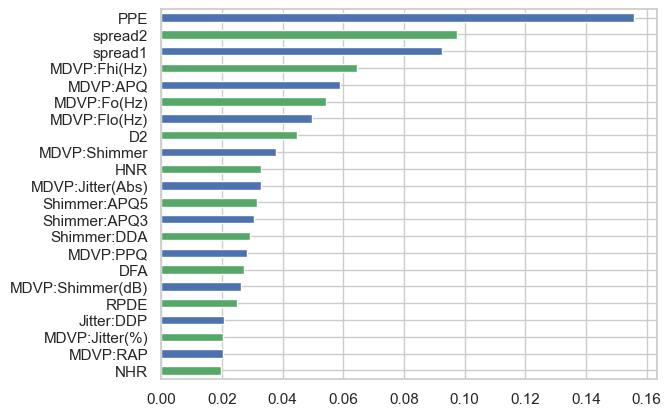

In [48]:
# plot the important features
rf.fit(X_train,y_train)
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh',color=['g','b'])

To Save the trained models we utilize PICKLE

In [49]:
import pickle

# Save the model to a file
filename = 'rf_model_parkinson'
pickle.dump(rf, open(filename, "wb"))

# Decision Tree Classifier

Visualizing the Decision Trees
using the dtreeviz library, we are able to visualize the decision tree. This can contribute to better the understanding of the role of our variables in identifying Parkinson.

At first, let's tune the parameters for the decision tree classifier:

In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'criterion': ['gini','entropy'],
    'max_depth': [2,4],
    'min_samples_split': [2,4],
    'min_samples_leaf': [1,2]
}

# Create a decison tree classifier
dt = DecisionTreeClassifier()

# use GridSearchCV to search for the best parameters
grid_search = GridSearchCV(dt,param_grid,cv=5,scoring='accuracy')
grid_search.fit(X_train,y_train)

#Print the best parameters and best score

print("Best parameters:",grid_search.best_params_)
print("Best recall score:",grid_search.best_score_)


Best parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best recall score: 0.8746031746031747


Apply the parameters to model:

In [51]:
clf = grid_search.best_estimator_
#same as
#clf = DecisionTreeClassifier(max_depth=2, min_samples_leaf=1, min_samples_split=2, criterion= 'entropy')
#clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

In [55]:
#!pip install graphviz
import os
os.environ["PATH"] += os.pathsep + 'Users/danishkarur/opt/anaconda3/lib/python3.9/site-packages (0.20.1)'#'C:/GraphViz/bin'

In [65]:
# Plot the tree
# plot the tree 
import dtreeviz

# Getting the list of variables
feature_names = list(X_train.columns)

# visualizing the tree
viz_model = dtreeviz.model(clf,
                           X_train=X_train, y_train=y_train, 
                           feature_names=feature_names)

v = viz_model.view(fancy=True)     # render as SVG into internal object 
print(v)

In [64]:
# get a random point
rand = np.random.randint(0, len(X))
sample_point = X.iloc[rand,:].values

# visualizing the path for the point
v = viz_model.view(fancy=True,scale=1.5,x=sample_point,show_just_path=True)
print(v)

In [2]:
import gradio as gr

def greet(name):
    return "Hello " + name + "!"

demo = gr.Interface(fn=greet, inputs="text", outputs="text")

demo.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
